### Preprocessing the data before training
To do: 
1. Load audio file, metadata
2. Split the file into 5-second segments
3. Create mel spectrogram for each audio segment
4. Save mel spectrogram with id, save id, bird specis in dataframe

In [1]:
# import the packages
import os
import pandas as pd
import numpy as np
import torchaudio
import torch 

import IPython.display as ipd
import matplotlib.pyplot as plt
import re



from utils import *

In [2]:
#define directories 
current_dir = os.getcwd() 
songs_path = os.path.join(current_dir, "Dataset\\songs\\songs") 
spectrograms_path = os.path.join(current_dir, "Dataset\\spectrograms") 
preprocessed_songs_path = os.path.join(current_dir, "Dataset\\preprocessed_songs") 

In [3]:
#load the metadata dataframe 
file_name = "Dataset\\birdsong_metadata.csv"
file_path = os.path.join(current_dir, file_name) 
print("Metadata directory:", file_path)
df_birdsongs_metadata = pd.read_csv(file_path)
display(df_birdsongs_metadata)

Metadata directory: C:\Users\bensa\Documents\Aberdeen University\University\Year 4\Session 2\EG4578\BirdClassification\Dataset\birdsong_metadata.csv


,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
...,...,...,...,...,...,...,...,...,...,...
259,132392,Turdus,philomelos,Song Thrush,david m,United Kingdom,54.1200,-0.5445,song,http://creativecommons.org/licenses/by-nc-nd/3.0/
260,146756,Turdus,philomelos,Song Thrush,David Darrell-Lambert,United Kingdom,51.6608,0.0031,song,http://creativecommons.org/licenses/by-nc-sa/3.0/
261,27060,Vanellus,vanellus,Northern Lapwing,Patrik berg,Sweden,58.4051,14.3028,song,http://creativecommons.org/licenses/by-nc-sa/3.0/
262,97982,Vanellus,vanellus,Northern Lapwing,Herman van der Meer,Netherlands,52.1520,4.3470,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/


In [4]:
unique_bird_names = set(df_birdsongs_metadata["english_cname"])
print("Birds: ", unique_bird_names)
print("Number of unique birds: ", len(unique_bird_names))

Birds:  {'Red-throated Loon', 'Willow Tit', 'Common Pheasant', 'European Turtle Dove', 'Rock Dove', 'Red Crossbill', 'European Herring Gull', 'Western Yellow Wagtail', 'Common Swift', 'Western Jackdaw', 'Marsh Warbler', 'Northern Lapwing', 'Eurasian Jay', 'Tawny Owl', 'River Warbler', 'Tree Pipit', 'Dunnock', 'Corn Bunting', 'European Robin', 'Common Redpoll', 'Eurasian Collared Dove', 'Carrion Crow', 'Eurasian Skylark', 'Coal Tit', 'Grey Partridge', 'Eurasian Magpie', 'Black-headed Gull', 'Common Redstart', 'Eurasian Reed Warbler', 'Great Spotted Woodpecker', 'House Sparrow', 'Common House Martin', 'Eurasian Treecreeper', 'Spotted Flycatcher', 'Common Reed Bunting', 'Grey Plover', 'Eurasian Blue Tit', 'Common Chiffchaff', 'European Goldfinch', 'Black Woodpecker', 'European Nightjar', 'Common Starling', 'Common Cuckoo', 'Common Chaffinch', 'Long-tailed Tit', 'Stock Dove', 'Eurasian Nuthatch', 'Common Redshank', 'Song Thrush', 'Rook', 'European Greenfinch', 'Eurasian Coot', 'Wood Warble

### Testing for 1 bird and then putting it in a loop that can process all audio samples

In [5]:

#testing 
sound_file = "xc132608.flac"
# sound_file = "xc132611.flac"
sound_file = "xc35068.flac"

sound_file_path = os.path.join(songs_path, sound_file)
print(sound_file_path)
print(os.path.isfile(sound_file_path))



C:\Users\bensa\Documents\Aberdeen University\University\Year 4\Session 2\EG4578\BirdClassification\Dataset\songs\songs\xc35068.flac
True


Shape of waveform: torch.Size([1, 223488])
Sample rate of waveform: 44100
Audio duration: 5.07 seconds


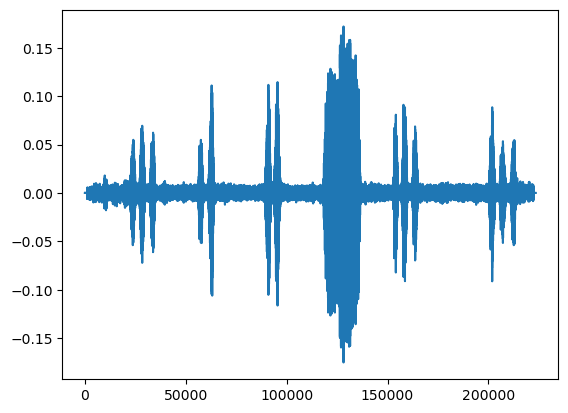

In [6]:

waveform, sample_rate = torchaudio.load(sound_file_path)
# print(f'Waveform tensor:  {waveform}' )
# print(f'Sample rate:  {sample_rate}' )
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
duration_in_seconds = round(waveform.size()[1] / sample_rate, 2)
print(f"Audio duration: {duration_in_seconds} seconds")

plt.figure()
plt.plot(waveform.t().numpy())

ipd.Audio(waveform.numpy(), rate=sample_rate)

Chunk 1: Duration 5.00 seconds


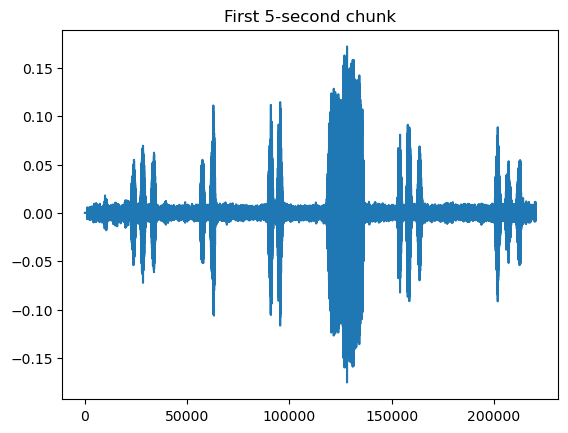

In [7]:
#split the audio into 5 second chuncks
waveform_chunks = AudioUtil.split_audio_into_chunks(waveform=waveform, sample_rate=sample_rate, 
                                          chunk_duration_s = 5.0, padded=True)

# Display information about the chunks
for i, chunk in enumerate(waveform_chunks):
    chunk_duration = chunk.size(1) / sample_rate
    print(f"Chunk {i + 1}: Duration {chunk_duration:.2f} seconds")

# Display the first chunk
plt.figure()
plt.plot(waveform_chunks[-1].t().numpy())
plt.title('First 5-second chunk')
plt.show()

# Listen to the first chunk
ipd.Audio(waveform_chunks[-1].numpy(), rate=sample_rate)


Shape of spectrogram: torch.Size([1, 401, 552])


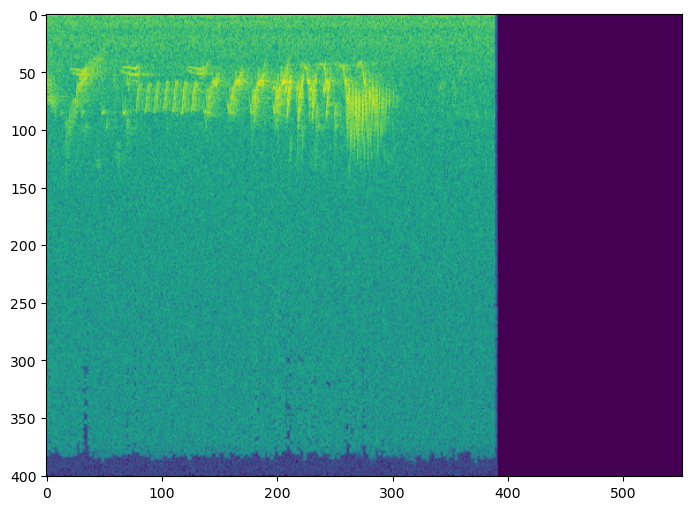

In [34]:
#create a spectrogram (frequency vs time)
transform = torchaudio.transforms.Spectrogram(n_fft=800, hop_length=400, win_length=800, center=True)
# test_spectrogram = transform(waveform)
test_spectrogram = transform(waveform_chunks[-1])

test_spectrogram = torchaudio.transforms.AmplitudeToDB()(test_spectrogram)

# test_spectrogram = torchaudio.transforms.Spectrogram()(waveform)
print("\nShape of spectrogram: {}".format(test_spectrogram.size()))

plt.figure(figsize=(10, 6))
plt.imshow(test_spectrogram[0,:,:].numpy())
# plt.imshow(test_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

In [ ]:
#create the mel spectrogram 
# mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,)
#                                                #      n_fft=800, hop_length=200, win_length=400, center=True)
# test_mel_spectrogram = mel_transform(waveform)
# print("Shape of spectrogram: {}".format(test_mel_spectrogram.size()))

# plt.figure()
# # plt.imshow(test_mel_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

In [35]:
# #save the spectrogram as an image 

# fig = plt.figure()
# img_name = "test.png"
# img_path = os.path.join(spectrograms_path, img_name)
# print(img_path)
# # #f'./data/spectrograms/{label_dir}/spec_img{i}.png'
# # plt.imsave(img_path, test_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

# # Plot and save the spectrogram
# plt.figure(figsize=(10, 6))
# plt.imshow(test_spectrogram.log2()[0, :, :].numpy(), cmap='viridis')

# # Save the plot as an image
# img_name = "test.png"
# img_path = os.path.join(spectrograms_path, img_name)
# plt.savefig(img_path)

### Split the dataset into chunks of 5s audio clips 
Save each clip with a number. For each clip put an entry into the dataframe 

relative path, original id, bird species


In [5]:
#row: id, original id, english_cname, relative_path
id_list = []
original_id_list = []
english_cname_list = []
path_list = []

#get all audio files 
audio_files = os.listdir(songs_path)

#regular expression pattern to extract the number after "xc"
pattern = re.compile(r'xc(\d+)\.flac')

#loop through each file
counter = 1
for file_name in audio_files:
    match = pattern.match(file_name)
    #if file matches the expected filename
    if match:
        extracted_number = int(match.group(1))
        
        #load the audio file 
        file_path = os.path.join(songs_path, file_name) 
        waveform, sample_rate = torchaudio.load(file_path)

        #split the audio into 5 second chunks
        waveform_chunks = AudioUtil.split_audio_into_chunks(waveform=waveform, sample_rate=sample_rate, 
                                                  chunk_duration_s = 5.0, padded=True)

        print(f"Filename: {file_name}, Number of chunks: {len(waveform_chunks)}")
        
        #save each chunk
        for waveform_chunk in waveform_chunks: 
            id_list.append(counter)
            original_id_list.append(extracted_number)
            english_cname_list.append(df_birdsongs_metadata.loc[df_birdsongs_metadata['file_id'] == extracted_number,'english_cname'].values[0])
            chunk_file_name = f"{counter}.flac"
            chunk_path = os.path.join(preprocessed_songs_path, chunk_file_name) 
            path_list.append(chunk_path)

            #save chunk 
            torchaudio.save(chunk_path, waveform_chunk, sample_rate)
            # print("Audio saved at:", chunk_path)
            counter += 1
    else: 
        print(f"File: {file_name} did not match")

data_dict = {
    "file_id": id_list, 
    "original_file_id": original_id_list, 
    "english_cname": english_cname_list, 
    "path": path_list, 
}

#convert the dictionary to a pandas DataFrame
df_metadata = pd.DataFrame(data_dict)

#assign a unique class id for each bird
bird_to_class_id = {bird: class_id for class_id, bird in enumerate(df_metadata['english_cname'].unique())}
#add class id to dataframe
df_metadata['class_id'] = df_metadata['english_cname'].map(bird_to_class_id)

#save metadata dataframe
file_name = "Dataset\\metadata.csv"
file_path = os.path.join(current_dir, file_name) 
df_metadata.to_csv(file_path, index=False)

Filename: xc101371.flac, Number of chunks: 5
Filename: xc101377.flac, Number of chunks: 15
Filename: xc101862.flac, Number of chunks: 14
Filename: xc101932.flac, Number of chunks: 4
Filename: xc101933.flac, Number of chunks: 4
Filename: xc101934.flac, Number of chunks: 6
Filename: xc101935.flac, Number of chunks: 11
Filename: xc101936.flac, Number of chunks: 5
Filename: xc101940.flac, Number of chunks: 14
Filename: xc101941.flac, Number of chunks: 5
Filename: xc102048.flac, Number of chunks: 5
Filename: xc102060.flac, Number of chunks: 31
Filename: xc102106.flac, Number of chunks: 5
Filename: xc102107.flac, Number of chunks: 18
Filename: xc102278.flac, Number of chunks: 6
Filename: xc102788.flac, Number of chunks: 22
Filename: xc102803.flac, Number of chunks: 9
Filename: xc102868.flac, Number of chunks: 5
Filename: xc102869.flac, Number of chunks: 10
Filename: xc102932.flac, Number of chunks: 19
Filename: xc103145.flac, Number of chunks: 7
Filename: xc106846.flac, Number of chunks: 16


In [8]:
unique_original_file_id_count = df_metadata['original_file_id'].nunique()
print(f'Number of unique original_file_id values: {unique_original_file_id_count}')
print(df_metadata['english_cname'].value_counts().to_dict())

# Display the DataFrame
display(df_metadata)
# print(df_birdsongs_metadata.dtypes)
display(df_birdsongs_metadata)

Number of unique original_file_id values: 264
{'Corn Bunting': 150, 'Eurasian Skylark': 117, 'Common Nightingale': 113, 'Barn Swallow': 106, 'Sedge Warbler': 102, 'Common Linnet': 101, 'Garden Warbler': 84, 'Eurasian Wryneck': 76, 'Common Starling': 76, 'Common Chaffinch': 73, 'Common Pheasant': 73, 'Song Thrush': 71, 'Eurasian Tree Sparrow': 70, 'Red-throated Loon': 64, 'Common Blackbird': 64, 'Willow Warbler': 63, 'European Robin': 62, 'Tawny Owl': 60, 'Meadow Pipit': 53, 'Common Moorhen': 51, 'Eurasian Reed Warbler': 51, 'European Golden Plover': 50, 'Northern Lapwing': 48, 'Common Chiffchaff': 47, 'Willow Ptarmigan': 45, 'Eurasian Golden Oriole': 45, 'Common House Martin': 44, 'Stock Dove': 44, 'Eurasian Bullfinch': 42, 'Common Wood Pigeon': 42, 'Eurasian Treecreeper': 41, 'Eurasian Wren': 40, 'Northern Raven': 39, 'Yellowhammer': 37, 'Western Yellow Wagtail': 37, 'Eurasian Blue Tit': 37, 'River Warbler': 37, 'Western Jackdaw': 36, 'Eurasian Oystercatcher': 36, 'European Herring Gu

,file_id,original_file_id,english_cname,path,class_id
0,1,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
1,2,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
2,3,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
3,4,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
4,5,101371,Long-tailed Tit,C:\Users\bensa\Documents\Aberdeen University\U...,0
...,...,...,...,...,...
3543,3544,99937,Eurasian Nuthatch,C:\Users\bensa\Documents\Aberdeen University\U...,75
3544,3545,99937,Eurasian Nuthatch,C:\Users\bensa\Documents\Aberdeen University\U...,75
3545,3546,99937,Eurasian Nuthatch,C:\Users\bensa\Documents\Aberdeen University\U...,75
3546,3547,99937,Eurasian Nuthatch,C:\Users\bensa\Documents\Aberdeen University\U...,75


,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
...,...,...,...,...,...,...,...,...,...,...
259,132392,Turdus,philomelos,Song Thrush,david m,United Kingdom,54.1200,-0.5445,song,http://creativecommons.org/licenses/by-nc-nd/3.0/
260,146756,Turdus,philomelos,Song Thrush,David Darrell-Lambert,United Kingdom,51.6608,0.0031,song,http://creativecommons.org/licenses/by-nc-sa/3.0/
261,27060,Vanellus,vanellus,Northern Lapwing,Patrik berg,Sweden,58.4051,14.3028,song,http://creativecommons.org/licenses/by-nc-sa/3.0/
262,97982,Vanellus,vanellus,Northern Lapwing,Herman van der Meer,Netherlands,52.1520,4.3470,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/


In [ ]:
#split the audio into 5 second chuncks
waveform_chunks = AudioUtil.split_audio_into_chunks(waveform=waveform, sample_rate=sample_rate, 
                                          chunk_duration_s = 5.0, padded=True)

# # Display information about the chunks
# for i, chunk in enumerate(waveform_chunks):
#     chunk_duration = chunk.size(1) / sample_rate
#     print(f"Chunk {i + 1}: Duration {chunk_duration:.2f} seconds")

# # Display the first chunk
# plt.figure()
# plt.plot(waveform_chunks[-1].t().numpy())
# plt.title('First 5-second chunk')
# plt.show()

# # Listen to the first chunk
# ipd.Audio(waveform_chunks[-1].numpy(), rate=sample_rate)


# Assuming waveform is the audio waveform you want to save
# # sound_file_path is the path where you want to save the audio file

# # Save the audio waveform
# torchaudio.save(sound_file_path, waveform, sample_rate)

# # Display the path for confirmation
# print("Audio saved at:", sound_file_path)